In [1]:
import numpy as np
import apogee.tools.read as apread
from matplotlib import pyplot as plt
import pandas as pd
import csv
from apogee.tools import bitmask
import math
from astropy.io import fits
import os.path
from pathlib import Path

In [2]:
#Calculate R-Values for given ranges
def calcR(x,pm):
    ccfCenter = max(x)
    primary = np.where(x == ccfCenter)
    peak_loc = primary[0][0]
    if peak_loc < pm: 
        pm = peak_loc
    if peak_loc > 401 - pm:
        pm = 401 - peak_loc
    if peak_loc == 0:
        r = 1000
        return r 
    endpoint = peak_loc+pm
    startpoint= peak_loc-pm
    Mirror = (x[peak_loc:endpoint])[::-1]
    sigmaA = np.sqrt(1.0 / (2.0 * len(Mirror)) * np.sum((x[startpoint:peak_loc] - Mirror)**2))
    r = np.max(x) / (np.sqrt(2.0) * sigmaA)
    return r

In [29]:
#Calculate the bisector points for a CCF (uses 4 points)
def bisector(xccf,yccf):
    height = max(yccf) - min(yccf)
    slices = height/4.0
    bounds = np.arange(min(yccf),height,slices)
    if len(bounds) != 0:
        z1 = (bounds[0] + bounds[1])/2.0
        z2 = (bounds[1] + bounds[2])/2.0
        z3 = (bounds[2] + bounds[3])/2.0
        z4 = (bounds[3] + bounds[4])/2.0
        y_bisector = np.array([z1,z2,z3,z4])

        x_bisector = []
        x0 = []
        x1 = []
        x2 = []
        x3 = []
        for i in range(len(yccf)):
            if yccf[i] <= bounds[4] and yccf[i] > bounds[3]:
                x0.append(xccf[i])
        x_0 = (np.mean(x0))
        x_bisector.append(x_0)

        i = 0
        for i in range(len(yccf)):
            if yccf[i] <= bounds[3] and yccf[i] >= bounds[2]:
                x1.append(xccf[i])
        x_1=(np.mean(x1))
        x_bisector.append(x_1)

        i = 0
        for i in range(len(yccf)):
            if yccf[i] <= bounds[2] and yccf[i] >= bounds[1]:
                x2.append(xccf[i])
        x_2=(np.mean(x2))
        x_bisector.append(x_2)

        i = 0
        for i in range(len(yccf)):
            if yccf[i] <= bounds[1] and yccf[i] >= bounds[0]:
                x3.append(xccf[i])
        x_3=(np.mean(x3))
        x_bisector.append(x_3)

        bisector_pts = np.vstack([x_bisector,y_bisector])
        #print(bisector_pts)
        return(bisector_pts)

def xrange(x_bisector):
    #print(x_bisector)
    xr = max(x_bisector) - min(x_bisector)
    return xr

In [55]:
#Find the R ratios of the SB2s
binR1 = []
binR2 = []
def r_ratio(r51,r151,r101):
        #print(r51, r101,r151)
        r1_ratio = r151/r101
        r2_ratio = r101/r51
        R1_ratio = math.log10(r1_ratio)
        R2_ratio = math.log10(r2_ratio)
        ratios = [round(R1_ratio,3),round(R2_ratio,3)]
        return ratios
'''for i in range(len(binApoID)):
    Ratios = r_ratio(R51s[i],R151s[i],R101s[i])
    r1 = Ratios[0]
    r2 = Ratios[1]
    binR1.append(r1)
    binR2.append(r2)''';

In [56]:
def idSB2s(R1_ratio, R2_ratio,r51,r151,r101,xr): # cuts to identify SB2s from Kevin's IDL Routine
    min_r51 = r51
    min_r101 = r101
    min_r151 = r151
    r1_ratio = R1_ratio
    r2_ratio = R2_ratio
    max_xr = xr
    
    likely_sb2s = np.where((math.log10(r1_ratio) > 0.06 and (math.log10(r1_ratio) < 0.13 and 
                            math.log10(min_r101) < 0.83)) or (math.log10(r2_ratio) > 0.05 and 
                            math.log10(r2_ratio) < 0.02 and math.log10(min_r51) < 0.83) and
                            math.log10(min_r51) > 0.25 and math.log10(min_r101) > 0.22 and
                            math.log10(peak_401) > -0.5 and math.log10(max_xr) < 2.3 and 
                            math.log10(max_xr) > 0.7
                          )
    return likely_sb2s

In [61]:
# Read in visually id SB2s
bins = pd.read_csv('KC_Binaries.csv',delimiter='\t')
locID = bins['Location_ID']
apoID = bins['Apogee_ID']
ids = bins['ID']
with open('KC_Binary_Stats.csv','w') as output:
    column = ['LocationID','ApogeeID','Visit','SNR','xRng','R51','R101','R151','R151/101','R101/51']
    writer = csv.DictWriter(output,delimiter='\t',fieldnames=column)
    writer.writeheader()
    
    binApoID = []
    binLocID = []
    R151s = []
    R101s = []
    R51s = []
    bin_xr = []
    for i in range(len(ids)):
        if ids[i] != 0:
            binApoID.append(apoID[i])
            binLocID.append(locID[i])
    print(len(binApoID))
    bin_SNR = []
    for j in range(len(binLocID)):
        locationID = binLocID[j]
        apogeeID = binApoID[j]
        my_file = Path('/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits')
        try: 
            path = '/Volumes/coveydata/APOGEE_Spectra/APOGEE2_DR14/dr14/apogee/spectro/redux/r8/stars/apo25m/'+str(locationID)+'/'+'apStar-r8-'+str(apogeeID)+'.fits'
            data = fits.open(path)
            point = data[9]
            xccf = point.data[0][32]
            CCF = point.data[0][27]
            HDU0 = fits.getheader(path,0)
            nvisits = HDU0['NVISITS']
            if nvisits != 1:
                for visit in range(0,nvisits):
                    ccf = CCF[visit+2]
                    snr = HDU0['SNRVIS'+str(visit+1)]
                    nonzeroes = np.count_nonzero(ccf) # This condition is meant to eliminate visits that are empty
                    if nonzeroes >= 1:
                        bs_pt = bisector(xccf, ccf)
                        x_range = xrange(bs_pt[0])
                        bin_xr.append(x_range)
                        bin_SNR.append(snr) 
                        R151 = calcR(ccf,75)
                        R101 = calcR(ccf,50)
                        R51 = calcR(ccf,25)
                        R151s.append(R151)
                        R101s.append(R101)
                        R51s.append(R51)
                        Ratios = r_ratio(R51,R151,R101)
                        r1 = Ratios[0]
                        r2 = Ratios[1]
                        writer.writerow({'LocationID':locationID,'ApogeeID':apogeeID,'Visit':visit,'SNR':snr,'xRng':round(x_range,3),
                                                     'R51':round(R51,3),'R101':round(R101,3),'R151':round(R151,3),'R151/101':r1,'R101/51':r2})
                    else:
                        pass

        except FileNotFoundError:
            #print('enter')
            pass

1071


In [28]:
dr14data = pd.read_csv('DR14_Stat_Catalog_Complete.csv',delimiter='\t')
all_r51 = dr14data['R51']
all_r101 = dr14data['R101']
all_r151 = dr14data['R151']
all_ratio1 = dr14data['R151/101']
all_ratio2 = dr14data['R101/51']
all_snr = dr14data['SNR']
all_xr = dr14data['xRng']
locationID = dr14data['Location_ID']
apogeeID = dr14data['Apogee_ID']
print(len(apogeeID))

943028


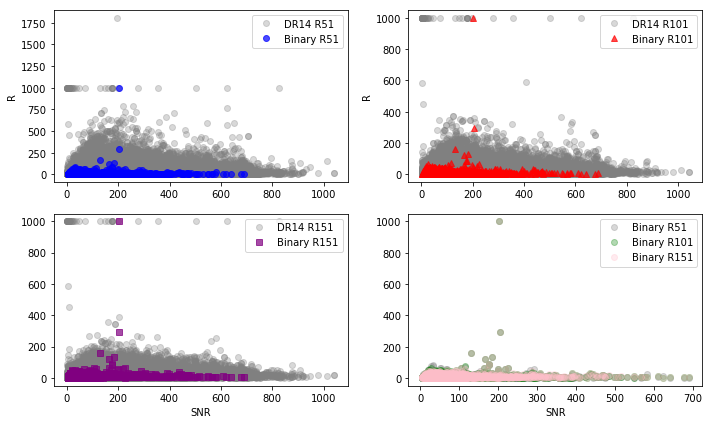

In [32]:
# Make graphs of all of DR14 snr vs R 151 values. Be sure to overplot the previously found binary values as well. 
fig = plt.figure(figsize=(10,6))

sub1 = plt.subplot(2,2,1)
sub1.plot(all_snr,all_r51, 'o', label='DR14 R51',alpha=0.3,color='grey')
sub1.plot(bin_SNR,R51s,'o', label = 'Binary R51',alpha=0.7,color='blue')
sub1.set_ylabel('R')
sub1.legend(loc='upper right')

sub2= plt.subplot(2,2,2)
sub2.plot(all_snr,all_r101, 'o', label='DR14 R101',alpha=0.3,color='grey')
sub2.plot(bin_SNR,R101s,'^',label='Binary R101',alpha=0.7,color='red')
sub2.set_ylabel('R')
sub2.legend(loc='upper right')

sub3 = plt.subplot(2,2,3)
sub3.set_xlabel('SNR')
sub3.plot(all_snr,all_r151, 'o', label='DR14 R151',alpha=0.3,color='grey')
sub3.plot(bin_SNR,R151s, 's',label='Binary R151',alpha=0.7,color='purple')
sub3.legend(loc='upper right')

sub4 = plt.subplot(2,2,4)
sub4.set_xlabel('SNR')
sub4.plot(bin_SNR,R51s, 'o', label='Binary R51',alpha=0.3,color='grey')
sub4.plot(bin_SNR,R101s,'o',label='Binary R101',alpha=0.3,color='green')
sub4.plot(bin_SNR,R151s,'o',label='Binary R151',alpha=0.3,color='pink')
sub4.legend(loc='upper right')

fig.tight_layout()
plt.savefig('All R vs SNR.pdf',dpi=400)
plt.show()

In [54]:
#Find the minimum Rs for 101, 151 and 51. Find the minimum ratios as well.
#Binaries first:
minR51 = []
minR101 = []
minR151 = []
minR1 = []
minR2 = []
for i in range(len(binApoID)):
    if binApoID[i] == binApoID[i+1]:
        print(binApoID[i],R51s[i])
    else:
        minR51.append(R51s[i])

IndexError: list index out of range

In [45]:
def arrays(x):
    x = np.array(x)
    new = x.astype(np.float)
    return new

In [52]:
#Convert binary lists to arrays
'''
binR2 = np.array(binR2)
binR2s = binR2.astype(np.float)
binR1 = np.array(binR1)
binR1s = binR1.astype(np.float)''';
binR51 = arrays(R51s)
binR101 = arrays(R101s)
binR151 = arrays(R151s)
binR1s = arrays(binR1)
binR2s = arrays(binR2)
print(type(binR51), type(binR2s))
print(binR51.shape, binR2s.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(4590,) (1071,)


In [50]:
# Generate R 51 vs  R101/51 (which is Ratio 2) histogram and contour plot for binaries then for DR14
import corner

#bindata = np.vstack([binR51,binR2s]).T
#labels = ['Min R51', 'log(R101/R51)']
#Bounds = [np.amin(bindata),np.amax(bindata)]

plt.figure(figsize=(8,8))
corner.hist2d(binR51,binR2s,bins=50,plot_contours=True,fill_contours=True,smooth=1.2,plot_datapoints=True)
plt.xlabel('R 51')
plt.ylabel('log( R101/R51)')
plt.show()

TypeError: Cannot cast array data from dtype('O') to dtype('float64') according to the rule 'safe'

In [115]:
# Read in the file and find how many are SB2s. 
with open('DR14_SB2_Catalog.csv','w') as files:
    column = ['Location_ID','Apogee_ID']
    writer = csv.DictWriter(files,delimiter='\t',fieldnames=column)
    writer.writeheader()
    i = 0
    r1 = []
    r2 = []
    r51 = []
    r101 = []
    r151 = []
    xranges = []
    SB2 = []
    for i in range(len(FieldID)):
        if Star_Visit[i] == Star_Visit[i]:
            r1.append(logR1[i])
            r2.append(logR2[i])
            r51.append(R51s[i])
            r101.append(R101s[i])
            r151.append(R151s[i])
            xranges.append(xr_value[i])
        '''likely_binary = idSB2s(r1[i], r2[i],r51[i],r151[i],r101[i],xranges[i])
        index_locID = FieldID[likely_binary]
        index_apoID = TwoMassID[likely_binary]
        SB2.append([index_locID,index_apoID])
        writer.writerow({'Location_ID': SB2[0] ,'Apogee_ID':SB2[1]})''';
print(r51)

IndexError: list index out of range